In this demo, we will be using the Air Passengers dataset to:

1. Fit a model using an ARIMA algorithm
2. Calculate forecasts

The initial steps are already covered in the previous demo.
Lets show model building here also.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings #for disable python warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install statsmodels==0.12.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [197]:
data = pd.read_csv('/content/AirPassengers.csv')#to read the file
     

data['Month'].head()#dataset consists of the date and monthly 

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [198]:
#Lets display the total monthly passenger count and using the lambda fxn to filter month
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
data = data.set_index('Month')#plot setting index to month
data.head()#Now lets see the data once

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [199]:
ts = data['#Passengers']#Assigning the passengers data time series variable


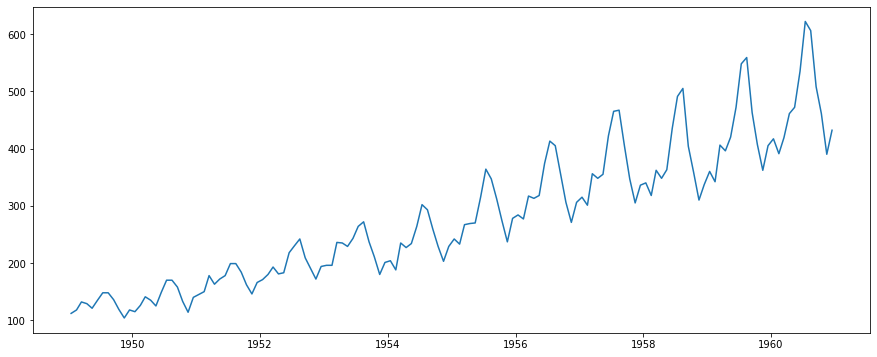

In [200]:
plt.plot(ts)#plotting the time series we get


In [201]:
ts_log = np.log(ts)#Transforming series using log D composition


In [202]:
def test_stationarity(timeseries):#stationarity check and these are the functions for performing rolling statistics and Dickey-Flutter Test
    rolmean = timeseries.rolling(window=52,center=False).mean()#Calculating rolling mean
    rolstd = timeseries.rolling(window=52,center=False).std()#Calculating rolling standard deviation

#Lets plot rolling statistics
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Flutter Test:')
    #Initializing the DF test variable
    dftest = adfuller(timeseries,autolag='AIC')
    #Initializing the output with the test statistic P value and other required variable
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used',
                                            'Number of Observations Used'])
    #Initializing te critical value variable, use a for-loop to 
    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

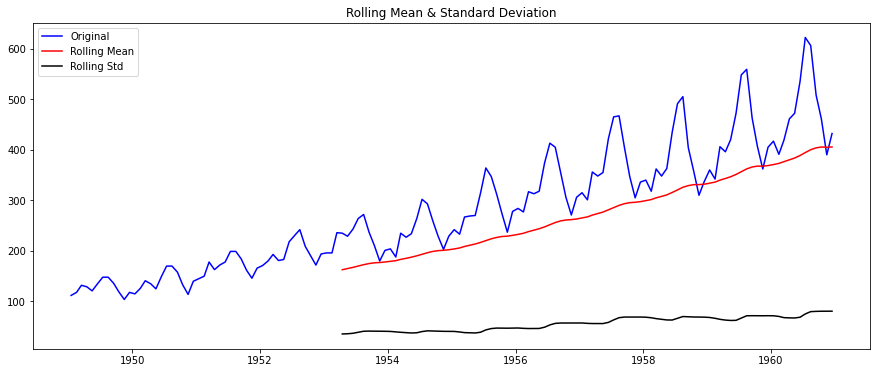

Results of Dickey-Flutter Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [203]:
#Now lets apply the data to the fxn. and see the results for stationary
test_stationarity(data['#Passengers'])

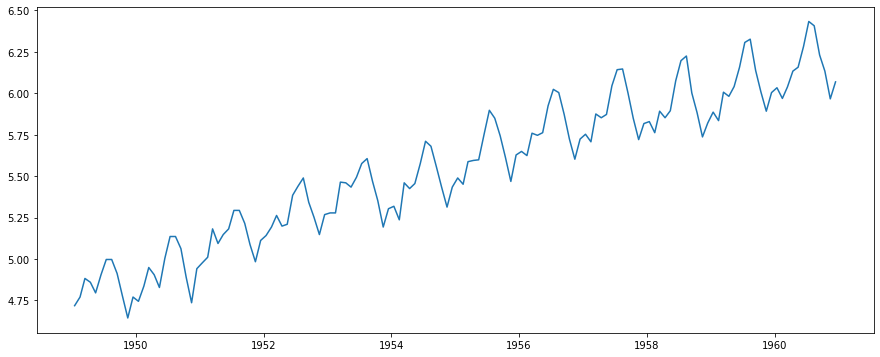

In [204]:
plt.plot(ts_log)#Lets also plot the moving average


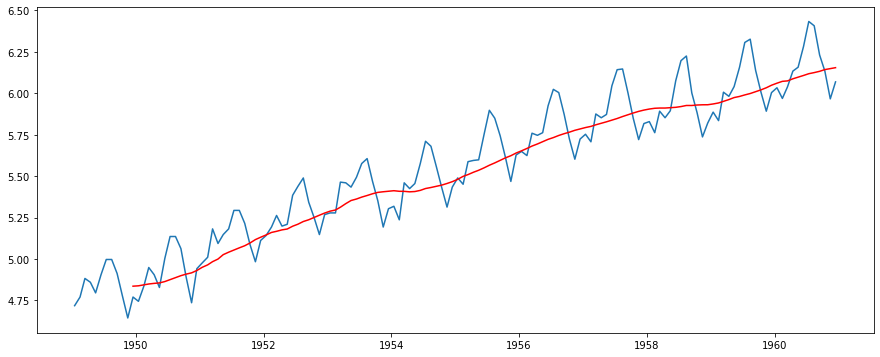

In [205]:
movingAverage = ts_log.rolling(window=12).mean()#Initializing the moving average variable.
movingSTD = ts_log.rolling(window=12).std()#Initializing the moving standard deviation variable
plt.plot(ts_log)#Plotting the data
plt.plot(movingAverage, color='red')#Plotting the moving averag

In [206]:

ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)#putting the first 12 values

ts_log_mv_diff.dropna(inplace=True)#lets drop the null values from the time series data
ts_log_mv_diff.head(10)
     

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

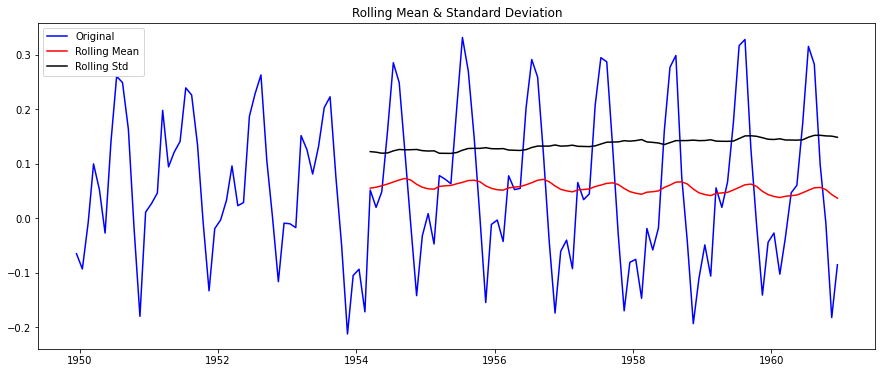

Results of Dickey-Flutter Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [207]:
test_stationarity(ts_log_mv_diff)#here we parse our time series data into this fxn and check for stationarity


**Forcasting a Time Series**

Now that we have made the time series sationary, let's make models on the time series. We wil use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.

To find out the p and q values for the model, we will use ACF and PACF plots.

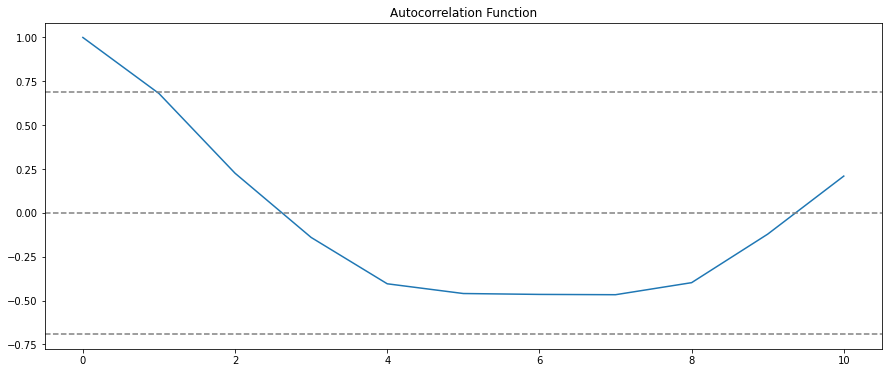

In [208]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

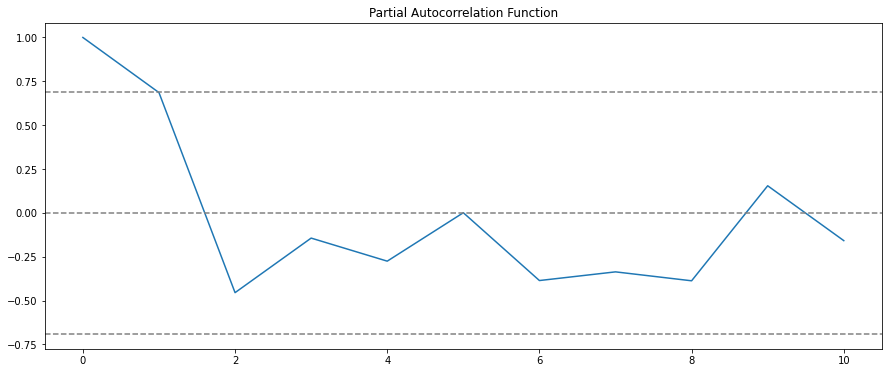

In [209]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS:  nan')

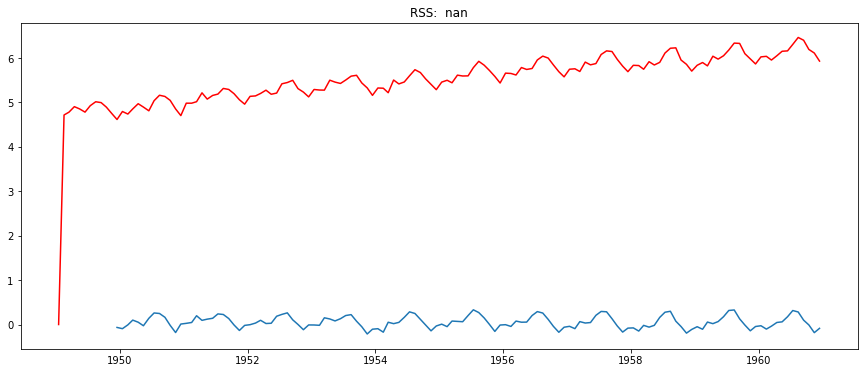

In [210]:
import statsmodels.api as smapi
model = ARIMA(ts_log, order=(1, 1, 0))
results_ARIMA = model.fit()
#Here I, stuck into the error while using results_ARIMA = model.fit(disp=-1) and by using results_ARIMA = model.fit() I got some variation in its output and also other next cells.
#And the error is "typeerror: fit() got an unexpected keyword argument 'disp'"
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [211]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-01-15    0.000000
1949-02-15    4.718499
1949-03-15    4.781405
1949-04-15    4.905833
1949-05-15    4.855090
dtype: float64

In [212]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-01-15     0.000000
1949-02-15     4.718499
1949-03-15     9.499904
1949-04-15    14.405737
1949-05-15    19.260827
dtype: float64

In [213]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15     4.718499
1949-02-15     9.436998
1949-03-15    14.218403
1949-04-15    19.124236
1949-05-15    23.979326
dtype: float64

Text(0.5, 1.0, 'RMSE: inf')

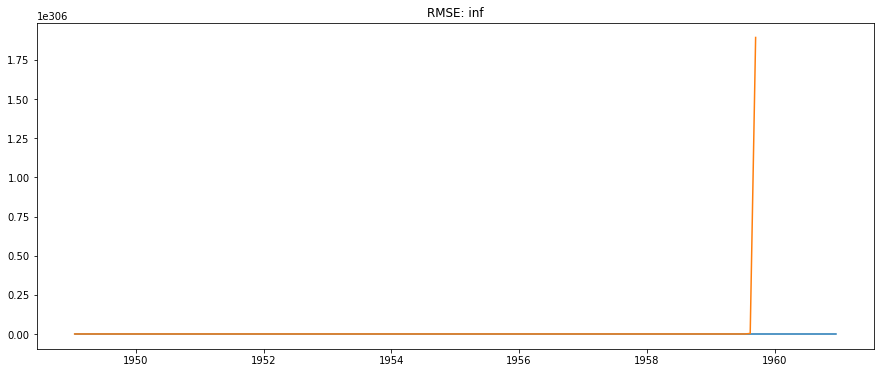

In [214]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
